In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import spacy
import re
import nltk
import textstat

nltk.download('punkt')
nltk.download('stopwords')
nlp = spacy.load("en_core_web_sm")

from langdetect import detect
from textblob import TextBlob
from nltk.tokenize import word_tokenize
from nltk import WordNetLemmatizer
from nltk import PorterStemmer
from nltk.corpus import stopwords
from collections import Counter
from wordcloud import WordCloud



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mperan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mperan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Read Twitter Data

In [12]:
path = '../data/raw/twitter_dataset.csv'

In [13]:
tweet = pd.read_csv(path)

In [14]:
tweet.head(5)

,Tweet_ID,Username,Text,Retweets,Likes,Timestamp
0,1,julie81,Party least receive say or single. Prevent pre...,2,25,2023-01-30 11:00:51
1,2,richardhester,Hotel still Congress may member staff. Media d...,35,29,2023-01-02 22:45:58
2,3,williamsjoseph,Nice be her debate industry that year. Film wh...,51,25,2023-01-18 11:25:19
3,4,danielsmary,Laugh explain situation career occur serious. ...,37,18,2023-04-10 22:06:29
4,5,carlwarren,Involve sense former often approach government...,27,80,2023-01-24 07:12:21


In [15]:
tweet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Tweet_ID   10000 non-null  int64 
 1   Username   10000 non-null  object
 2   Text       10000 non-null  object
 3   Retweets   10000 non-null  int64 
 4   Likes      10000 non-null  int64 
 5   Timestamp  10000 non-null  object
dtypes: int64(3), object(3)
memory usage: 468.9+ KB


Exploration

In [16]:
tweet.shape

(10000, 6)

In [17]:
tweet.nunique()

Tweet_ID     10000
Username      9447
Text         10000
Retweets       101
Likes          101
Timestamp     9993
dtype: int64

In [18]:
# Check for Nan values
tweet.isna().sum()

Tweet_ID     0
Username     0
Text         0
Retweets     0
Likes        0
Timestamp    0
dtype: int64

In [19]:
# Explore random tweets to understand the kind of text
print(tweet.iloc[0,2])
print(tweet.iloc[10,2])

Party least receive say or single. Prevent prevent husband affect. May himself cup style evening protect. Effect another themselves stage perform.
Possible try tax share style television with. Successful much sell development economy effect.
Image simply article list event imagine want reach. Floor best west human American plant. Board scientist party suggest exactly.
Computer product one.


Preprocessing

In [20]:
# Change the Timestamp to the correct datetime format

tweet['Timestamp'] = pd.to_datetime(tweet['Timestamp'], format='%Y-%m-%d %H:%M:%S')

tweet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Tweet_ID   10000 non-null  int64         
 1   Username   10000 non-null  object        
 2   Text       10000 non-null  object        
 3   Retweets   10000 non-null  int64         
 4   Likes      10000 non-null  int64         
 5   Timestamp  10000 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 468.9+ KB


In [21]:
# Drop duplicates
tweet.drop_duplicates(subset='Text', keep='first', inplace=True)


In [22]:
languages = []

# Loop over the sentences in the list and detect their language
for sentence in tweet["Text"]:
    languages.append(detect(sentence))
    
# Assign the list to a new feature 
tweet['language'] = languages

tweet = tweet[tweet['language'] == "en"]

Data Cleaning

In [23]:
# Clean the document
nltk.download('stopwords')
nlp = spacy.load('en_core_web_sm')
nlp.disable_pipes('ner',"tagger","parser")
stop_words = nltk.corpus.stopwords.words('english') # initialize the stop word list

# Define the list of stopwords
stop_words = set(stopwords.words('english'))

def normalize_document(tweet):
    # Lowercase and remove special characters/whitespaces
    tweet = re.sub(r'[^a-zA-Z0-9\s]', '', tweet, re.I|re.A)
    tweet = tweet.lower().strip()

    # Remove multiple white spaces. Reduce these to singlw white spaces
    tweet = re.sub(r'\s+', ' ', tweet).strip()

    # Remove URLs and mentions
    tweet = re.sub(r"http\S+", "", tweet)
    tweet = re.sub(r"@\S+", "", tweet)

    # Remove next lines and replace with a space
    tweet = re.sub(r'\n', ' ', tweet)

    # Tokenization
    tokens = word_tokenize(tweet)

    # remove numbers
    tokens = [token for token in tokens if not token.isnumeric()]

    # Remove stopwords
    filtered_tokens =[token for token in tokens if token not in stop_words]

    # Correct spelling errors using TextBlob
    corrected_tokens = [str(TextBlob(token).correct()) for token in filtered_tokens]

    # Lemmatization with spaCy
    # Convert tokens back to one single string for spaCy processing
    processed_text = ' '.join(corrected_tokens)
    doc = nlp(processed_text)
    lemmatized_tokens = [token.lemma_ for token in doc]

    return lemmatized_tokens


# Apply preprocessing
tweet['processed_text'] = tweet['Text'].apply(normalize_document)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mperan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
c:\Users\mperan\.conda\envs\py\Lib\site-packages\spacy\pipeline\lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


In [24]:
# Generate the cleaned tweets
norm_tweets = [normalize_document(r) for r in tweet["Text"]]

norm_tweets_list= [i for b in norm_tweets for i in b]

c:\Users\mperan\.conda\envs\py\Lib\site-packages\spacy\pipeline\lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


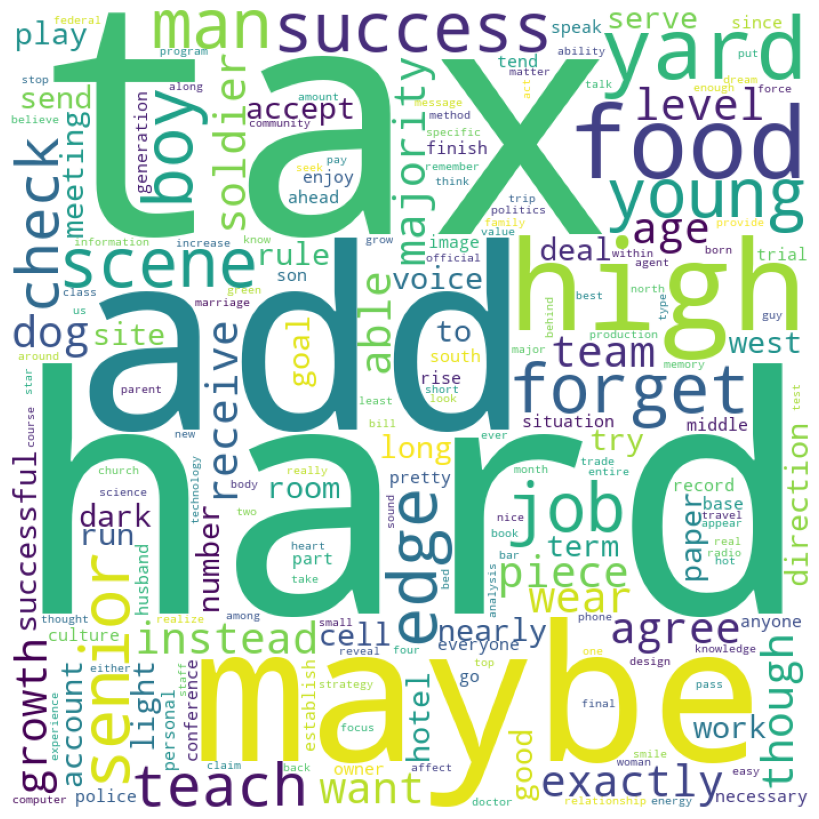

In [25]:
# Creating the word cloud from the frequency of occurence of words

frequency_cleaned = Counter(norm_tweets_list)

wordcloud = WordCloud(width = 700, height = 700,
                background_color ='white',
                min_font_size = 10)

wordcloud.generate_from_frequencies(frequency_cleaned)
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

## Feature Extraction

Sentiment Analysis

Explore Sentiment analysis using the VADER(Valence Aware Dictionary and sEntiment Reasoner) lexicon; which is a popular rules based sentiment analysis lexicon for social media. It incorporates Slangs, emojis and other formats unique to social media. It is made up of
1. neg (Negative sentiment):
ii. pos (Positive sentiment)
iii. neu (Neutral sentiment)
iv. compound (Overall sentiment of the text with range -1 to 1)

This step seeks to analyse the overall sentiment of the tweet

In [27]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

def add_sentiment_scores(tweet):
    sid = SentimentIntensityAnalyzer()
    
    # Apply the polarity_scores method to each text
    sentiments = tweet['Text'].apply(sid.polarity_scores)
    sentiments_df = pd.DataFrame(sentiments.tolist())
    sentiments_df.columns = ['neg_tweet_sentiment', 'neu_tweet_sentiment', 'pos_tweet_sentiment', 'tweet_sentiment_compound']
    tweet = tweet.join(sentiments_df)
    
    return tweet


# Add sentiment scores to the DataFrame
tweet = add_sentiment_scores(tweet)

# Display the first few rows of the DataFrame to check the new sentiment columns
tweet.head(5)

,Tweet_ID,Username,Text,Retweets,Likes,Timestamp,language,processed_text,neg_tweet_sentiment,neu_tweet_sentiment,pos_tweet_sentiment,tweet_sentiment_compound
0,1,julie81,Party least receive say or single. Prevent pre...,2,25,2023-01-30 11:00:51,en,"[party, least, receive, say, single, prevent, ...",0.00,0.675,0.325,0.8885
1,2,richardhester,Hotel still Congress may member staff. Media d...,35,29,2023-01-02 22:45:58,en,"[hotel, still, congress, may, member, staff, m...",0.00,0.929,0.071,0.2960
2,3,williamsjoseph,Nice be her debate industry that year. Film wh...,51,25,2023-01-18 11:25:19,en,"[nice, debate, industry, year, film, generatio...",0.00,0.765,0.235,0.8481
3,4,danielsmary,Laugh explain situation career occur serious. ...,37,18,2023-04-10 22:06:29,en,"[laugh, explain, situation, career, occur, ser...",0.04,0.795,0.165,0.6249
4,5,carlwarren,Involve sense former often approach government...,27,80,2023-01-24 07:12:21,en,"[involve, sense, former, often, approach, gove...",0.00,0.847,0.153,0.6705


This step of sentiment analysis is to calculate the sentiment scores per aspect of the tweet using the Aspect-Based Sentiment Analysis (ABSA). We attempted to integrate the SetFitABSA model, developed by Hugging Face and Intel Labs, to perform Aspect-Based Sentiment Analysis (ABSA) on tweets, however, there were several unresolved issues around importing SetFit. Transformers were also explored, using pipelines and torch, but we were met with limited resources to run these. Therefore, Textblob (which is the least preferred option was utilised) was used to achieve the same results which allows the extraction of key aspects of the different tweets and analyze the sentiments associated with these aspects.

In [ ]:
# from gensim.corpora import Dictionary
# from gensim.models import LdaModel
# from nltk.tokenize import RegexpTokenizer
# from transformers import pipeline
# from setfit import load_dataset, AbsaTrainer, AbsaModel
# from nltk.sentiment.vader import SentimentIntensityAnalyzer
# from gensim.models import Word2Vec, LdaMulticore
# from gensim.corpora.dictionary import Dictionary
# from readability import Readability
# from transformers import AutoTokenizer, AutoModelForSequenceClassification
# from sklearn.feature_extraction.text import CountVectorizer

In [29]:
import spacy
from textblob import TextBlob
import pandas as pd

# Load English tokenizer, tagger, parser, NER, and word vectors from spaCy
nlp = spacy.load('en_core_web_sm')

def extract_aspects(tokens):
    """ Extracts noun phrases from a list of tokens using spaCy. """
    text = ' '.join(tokens)  # Join tokens into a single string
    doc = nlp(text)
    return [chunk.text for chunk in doc.noun_chunks]

def analyze_aspect_sentiments(text, aspects):
    """ Analyzes sentiment for each aspect using TextBlob. """
    aspect_sentiments = {}
    for aspect in aspects:
        blob = TextBlob(aspect)
        sentiment = blob.sentiment
        if sentiment.polarity > 0:
            sentiment_label = 'Positive'
        elif sentiment.polarity < 0:
            sentiment_label = 'Negative'
        else:
            sentiment_label = 'Neutral'
        aspect_sentiments[aspect] = sentiment_label
    return aspect_sentiments


# Apply to tweet
tweet['Aspects'] = tweet['processed_text'].apply(extract_aspects)
tweet['AspectSentiments'] = tweet.apply(lambda row: analyze_aspect_sentiments(row['processed_text'], row['Aspects']), axis=1)


In [ ]:
# # Throwing Errors
# # Load English tokenizer, tagger, parser, NER, and word vectors
# #nlp = spacy.load('en_core_web_sm')

# # Explicitly specify the model for sentiment analysis
# #model_name = "distilbert-base-uncased-finetuned-sst-2-english"
# #sentiment_pipeline = pipeline('sentiment-analysis', model=model_name)

# #def extract_aspects(text):
#     """ Extracts noun phrases as potential aspects using spaCy. """
#     doc = nlp(text)
#     aspects = [chunk.text for chunk in doc.noun_chunks]
#     return aspects

# def analyze_aspect_sentiments(text, aspects, sentiment_pipeline):
#     """ Analyzes sentiment for each aspect using the Hugging Face pipeline. """
#     aspect_sentiments = {}
#     for aspect in aspects:
#         # Contextualize aspect with the original sentence
#         sentiment = sentiment_pipeline(f"{aspect} in context: {text}")
#         aspect_sentiments[aspect] = sentiment[0]['label']
#     return aspect_sentiments


# # Initialize empty dictionaries to store aspect and sentiment columns
# aspect_columns = {}
# sentiment_columns = {}

# # Iterate over the DataFrame to fill the dictionaries
# for index, row in tweet.iterrows():
#     # Extract aspects from the processed text
#     aspects = extract_aspects(row['processed_text'])
#     # Get the sentiments for the extracted aspects
#     aspect_sentiments = analyze_aspect_sentiments(row['processed_text'], aspects, sentiment_pipeline)
#     # Create columns for aspects and their sentiments
#     for aspect, sentiment in aspect_sentiments.items():
#         aspect_key = f'Aspect_{aspect.replace(" ", "_")}'
#         sentiment_key = f'Sentiment_{aspect.replace(" ", "_")}'
#         aspect_columns.setdefault(aspect_key, []).append(aspect)
#         sentiment_columns.setdefault(sentiment_key, []).append(sentiment)

# # Convert the dictionaries to DataFrames and join them with the original DataFrame
# aspect_df = pd.DataFrame(aspect_columns)
# sentiment_df = pd.DataFrame(sentiment_columns)

# # Aligning the DataFrame index with that of the original DataFrame
# aspect_df.index = tweet.index
# sentiment_df.index = tweet.index

# # Joining the new columns to the original DataFrame
# tweet = tweet.join(aspect_df).join(sentiment_df)

# # Display the DataFrame with new features
# print(tweet.head(5))


Readability Scores

1a. Add Readabilty score to each Tweet to show how readable (or understandable) each tweet is. This shows the complexity of the tweets. The summary of scores include:
i. Flesch Reading Ease: Score Range: 0-100 (standard = 60 - 70. Lower scores are more difficult).
b. SMOG Index: Score Range: Typically 3-12 (corresponds to US grading system)
c. Flesch-Kincaid Grade Level: Similar to SMOG. 

In [30]:
# Function to add readability scores to the DataFrame
def add_readability_scores(tweet):
    tweet['flesch_reading_ease'] = tweet['Text'].apply(textstat.flesch_reading_ease)
    tweet['smog_index'] = tweet['Text'].apply(textstat.smog_index)
    tweet['flesch_kincaid_grade'] = tweet['Text'].apply(textstat.flesch_kincaid_grade)
    return tweet

# Adding readability scores
tweet = add_readability_scores(tweet)
tweet.head(5)


,Tweet_ID,Username,Text,Retweets,Likes,Timestamp,language,processed_text,neg_tweet_sentiment,neu_tweet_sentiment,pos_tweet_sentiment,tweet_sentiment_compound,Aspects,AspectSentiments,flesch_reading_ease,smog_index,flesch_kincaid_grade
0,1,julie81,Party least receive say or single. Prevent pre...,2,25,2023-01-30 11:00:51,en,"[party, least, receive, say, single, prevent, ...",0.00,0.675,0.325,0.8885,"[party, may cup style evening protect, effect,...","{'party': 'Neutral', 'may cup style evening pr...",48.77,8.8,7.9
1,2,richardhester,Hotel still Congress may member staff. Media d...,35,29,2023-01-02 22:45:58,en,"[hotel, still, congress, may, member, staff, m...",0.00,0.929,0.071,0.2960,"[hotel, still congress, may member staff media...","{'hotel': 'Neutral', 'still congress': 'Neutra...",65.39,7.6,5.6
2,3,williamsjoseph,Nice be her debate industry that year. Film wh...,51,25,2023-01-18 11:25:19,en,"[nice, debate, industry, year, film, generatio...",0.00,0.765,0.235,0.8481,[nice debate industry year film generation pus...,{'nice debate industry year film generation pu...,48.97,9.3,7.8
3,4,danielsmary,Laugh explain situation career occur serious. ...,37,18,2023-04-10 22:06:29,en,"[laugh, explain, situation, career, occur, ser...",0.04,0.795,0.165,0.6249,"[situation career, serious five particular imp...","{'situation career': 'Neutral', 'serious five ...",48.67,10.4,7.9
4,5,carlwarren,Involve sense former often approach government...,27,80,2023-01-24 07:12:21,en,"[involve, sense, former, often, approach, gove...",0.00,0.847,0.153,0.6705,"[sense, second image, production thousand natu...","{'sense': 'Neutral', 'second image': 'Neutral'...",49.58,8.1,7.6


In [31]:

def extract_text_features(tweet):
    # Assuming 'data' is a DataFrame with a column named 'text' for the tweets
    tweet['tweet_length'] = tweet['Text'].apply(len)
    tweet['hashtag_count'] = tweet['Text'].apply(lambda x: len(re.findall(r"#(\w+)", x)))
    tweet['mention_count'] = tweet['Text'].apply(lambda x: len(re.findall(r"@(\w+)", x)))
    tweet['url_count'] = tweet['Text'].apply(lambda x: len(re.findall(r"http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+", x)))
    return tweet

tweet = extract_text_features(tweet)
tweet.head(5)


,Tweet_ID,Username,Text,Retweets,Likes,Timestamp,language,processed_text,neg_tweet_sentiment,neu_tweet_sentiment,...,tweet_sentiment_compound,Aspects,AspectSentiments,flesch_reading_ease,smog_index,flesch_kincaid_grade,tweet_length,hashtag_count,mention_count,url_count
0,1,julie81,Party least receive say or single. Prevent pre...,2,25,2023-01-30 11:00:51,en,"[party, least, receive, say, single, prevent, ...",0.00,0.675,...,0.8885,"[party, may cup style evening protect, effect,...","{'party': 'Neutral', 'may cup style evening pr...",48.77,8.8,7.9,241,0,0,0
1,2,richardhester,Hotel still Congress may member staff. Media d...,35,29,2023-01-02 22:45:58,en,"[hotel, still, congress, may, member, staff, m...",0.00,0.929,...,0.2960,"[hotel, still congress, may member staff media...","{'hotel': 'Neutral', 'still congress': 'Neutra...",65.39,7.6,5.6,190,0,0,0
2,3,williamsjoseph,Nice be her debate industry that year. Film wh...,51,25,2023-01-18 11:25:19,en,"[nice, debate, industry, year, film, generatio...",0.00,0.765,...,0.8481,[nice debate industry year film generation pus...,{'nice debate industry year film generation pu...,48.97,9.3,7.8,219,0,0,0
3,4,danielsmary,Laugh explain situation career occur serious. ...,37,18,2023-04-10 22:06:29,en,"[laugh, explain, situation, career, occur, ser...",0.04,0.795,...,0.6249,"[situation career, serious five particular imp...","{'situation career': 'Neutral', 'serious five ...",48.67,10.4,7.9,201,0,0,0
4,5,carlwarren,Involve sense former often approach government...,27,80,2023-01-24 07:12:21,en,"[involve, sense, former, often, approach, gove...",0.00,0.847,...,0.6705,"[sense, second image, production thousand natu...","{'sense': 'Neutral', 'second image': 'Neutral'...",49.58,8.1,7.6,274,0,0,0


Named Entity Recognition (NER)

In [32]:
nlp = spacy.load("en_core_web_sm") 

# Function to extract named entities
def extract_entities(token_list):
    text = ' '.join(token_list)
    doc = nlp(text)
    return [ent.text for ent in doc.ents]

# Assuming 'tweet' is your DataFrame and 'processed_text' contains lists of tokens
tweet['entities'] = tweet['processed_text'].apply(extract_entities)


In [33]:
 # Count the number of entities per tweet


# Function to extract and count named entities
def count_entities(token_list):
    # Join the list of tokens into a single string
    text = ' '.join(token_list)
    doc = nlp(text)
    # Return the count of named entities
    return len(doc.ents)

# Assuming 'tweet' is your DataFrame and 'processed_text' contains lists of tokens
tweet['entity_count'] = tweet['processed_text'].apply(count_entities)


In [34]:
tweet.head(5)

,Tweet_ID,Username,Text,Retweets,Likes,Timestamp,language,processed_text,neg_tweet_sentiment,neu_tweet_sentiment,...,AspectSentiments,flesch_reading_ease,smog_index,flesch_kincaid_grade,tweet_length,hashtag_count,mention_count,url_count,entities,entity_count
0,1,julie81,Party least receive say or single. Prevent pre...,2,25,2023-01-30 11:00:51,en,"[party, least, receive, say, single, prevent, ...",0.00,0.675,...,"{'party': 'Neutral', 'may cup style evening pr...",48.77,8.8,7.9,241,0,0,0,[evening],1
1,2,richardhester,Hotel still Congress may member staff. Media d...,35,29,2023-01-02 22:45:58,en,"[hotel, still, congress, may, member, staff, m...",0.00,0.929,...,"{'hotel': 'Neutral', 'still congress': 'Neutra...",65.39,7.6,5.6,190,0,0,0,"[hotel, congress, another turn minute]",3
2,3,williamsjoseph,Nice be her debate industry that year. Film wh...,51,25,2023-01-18 11:25:19,en,"[nice, debate, industry, year, film, generatio...",0.00,0.765,...,{'nice debate industry year film generation pu...,48.97,9.3,7.8,219,0,0,0,[],0
3,4,danielsmary,Laugh explain situation career occur serious. ...,37,18,2023-04-10 22:06:29,en,"[laugh, explain, situation, career, occur, ser...",0.04,0.795,...,"{'situation career': 'Neutral', 'serious five ...",48.67,10.4,7.9,201,0,0,0,"[five, billion]",2
4,5,carlwarren,Involve sense former often approach government...,27,80,2023-01-24 07:12:21,en,"[involve, sense, former, often, approach, gove...",0.00,0.847,...,"{'sense': 'Neutral', 'second image': 'Neutral'...",49.58,8.1,7.6,274,0,0,0,"[second, one]",2


Word Embeddings

Topic Modelling using LDA

In [35]:
# Step 1: Import necessary libraries
from gensim.corpora import Dictionary
from gensim.models import LdaModel
import pandas as pd
import nltk
nltk.download('punkt')

# Step 3: If your 'processed_text' is already in list format, skip tokenization
# tweet['tokenized_text'] = tweet['processed_text'].apply(nltk.word_tokenize)

# Step 4: Create a dictionary and corpus needed for Topic Modeling
dictionary = Dictionary(tweet['processed_text'])
corpus = [dictionary.doc2bow(text) for text in tweet['processed_text']]

# Step 5: Train LDA model
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=5, random_state=100, update_every=1, passes=10, alpha='auto', per_word_topics=True)

# Step 6: Extract topics for each tweet
def get_lda_topics(bow):
    return lda_model.get_document_topics(bow)

tweet['lda_topics'] = [get_lda_topics(bow) for bow in corpus]


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mperan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [36]:
tweet.head(5)

,Tweet_ID,Username,Text,Retweets,Likes,Timestamp,language,processed_text,neg_tweet_sentiment,neu_tweet_sentiment,...,flesch_reading_ease,smog_index,flesch_kincaid_grade,tweet_length,hashtag_count,mention_count,url_count,entities,entity_count,lda_topics
0,1,julie81,Party least receive say or single. Prevent pre...,2,25,2023-01-30 11:00:51,en,"[party, least, receive, say, single, prevent, ...",0.00,0.675,...,48.77,8.8,7.9,241,0,0,0,[evening],1,"[(0, 0.5195089), (4, 0.4705122)]"
1,2,richardhester,Hotel still Congress may member staff. Media d...,35,29,2023-01-02 22:45:58,en,"[hotel, still, congress, may, member, staff, m...",0.00,0.929,...,65.39,7.6,5.6,190,0,0,0,"[hotel, congress, another turn minute]",3,"[(2, 0.88688934), (3, 0.10121173)]"
2,3,williamsjoseph,Nice be her debate industry that year. Film wh...,51,25,2023-01-18 11:25:19,en,"[nice, debate, industry, year, film, generatio...",0.00,0.765,...,48.97,9.3,7.8,219,0,0,0,[],0,"[(0, 0.23296742), (2, 0.756235)]"
3,4,danielsmary,Laugh explain situation career occur serious. ...,37,18,2023-04-10 22:06:29,en,"[laugh, explain, situation, career, occur, ser...",0.04,0.795,...,48.67,10.4,7.9,201,0,0,0,"[five, billion]",2,"[(4, 0.9847922)]"
4,5,carlwarren,Involve sense former often approach government...,27,80,2023-01-24 07:12:21,en,"[involve, sense, former, often, approach, gove...",0.00,0.847,...,49.58,8.1,7.6,274,0,0,0,"[second, one]",2,"[(0, 0.30399212), (4, 0.6871857)]"


Using BERT

In [1]:
from transformers import BertTokenizer, TFBertForSequenceClassification, TFTrainer, TFTrainingArguments
import tensorflow as tf

## Initialize tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the data
def tokenize_function(examples):
    return tokenizer(examples['text'], padding="max_length", truncation=True, max_length=128)

tokenized_datasets = tweet.apply(tokenize_function, axis=1)
dataset = tf.data.Dataset.from_tensor_slices((
    dict(tokenized_datasets),
    tweet['label'].values
))



ImportError: 
TFAutoModelForSequenceClassification requires the TensorFlow library but it was not found in your environment.
However, we were able to find a PyTorch installation. PyTorch classes do not begin
with "TF", but are otherwise identically named to our TF classes.
If you want to use PyTorch, please use those classes instead!

If you really do want to use TensorFlow, please follow the instructions on the
installation page https://www.tensorflow.org/install that match your environment.


In [ ]:
# Step 2: Import necessary libraries
import pandas as pd
from transformers import BertModel, BertTokenizer
import Pytorch

# Step 3: Load pre-trained BERT model and tokenizer
model_name = 'bert-base-uncased'  # You can also try other pre-trained models like 'bert-base-cased' or 'bert-large-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)


# Step 5: Tokenize and encode the tweets using BERT tokenizer
tokenized_tweets = tweet['processed_text'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

# Step 6: Pad sequences to ensure uniform length
max_len = max(map(len, tokenized_tweets))
padded_tweets = Pytorch.tensor([i + [0]*(max_len-len(i)) for i in tokenized_tweets])

# Step 7: Obtain BERT embeddings
with Pytorch.no_grad():
    outputs = model(padded_tweets)

# Step 8: Extract embeddings of [CLS] token, which typically represents the entire tweet
bert_embeddings = outputs[0][:, 0, :].numpy()




: 

Exploratory Data Analysis

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting distribution of sentiment
sns.histplot(tweets['sentiment'], kde=True)
plt.title('Distribution of Sentiment Scores')
plt.show()

# Correlation heatmap
correlation = tweets[['sentiment', 'hashtag_count', 'mention_count', 'engagement']].corr()  # Define 'engagement' correctly
sns.heatmap(correlation, annot=True)
plt.show()


Model Building

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Prepare data for training
X = tweets[['sentiment', 'hashtag_count', 'mention_count']]  # Add more features as needed
y = tweets['engagement']  # Make sure 'engagement' is correctly defined

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict on test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
